In [1]:
import pandas as pd
import numpy as np
import json
import os
import time
import math
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import configs

In [ ]:
# settings from configs.py file

dataset = configs.data_source # 'politifact' or 'gossipcop'
label_or_class = configs.fake_or_real # 'fake' or 'real'

hours = configs.detection_deadline # detection time in hours

# Extracted features for each node in propagation network

<ol>
<li>The creation time of the tweet or retweet</li>
<li>The number of retweets - is the same value for all nodes in a cascade</li>
<li>The number of favorites - the value of all nodes in each cascade is zero except for first</li>
<li>The length of tweet or retweet - the value of all nodes in each cascade is the same except for first</li>
<li>-The sentiment_compound of the tweet's text</li>
<li>-The frequency of positive words</li>
<li>-The frequency of negative words</li>
<li>-The number of hashtags</li>
<li>-The number of mentions</li>
<li>1:verified, 0:unverified</li>
<li>The number of followers</li>
<li>The number of followings or friends</li>
<li>The number of lists</li>
<li>The creation time of the user</li>
<li>The number of favourites of the user in hand</li>
<li>The number of tweets of the user in hand</li>
</ol>

# Extracting important features for each tweet_id in the propagation tree

In [4]:
# load the propagation trees from a json file
file_name = '{}_{}_propagation_{}hours_free_len_shortest_first.json'.format(dataset, label_or_class, hours)
with open(file_name) as json_file:
    propagation_trees = json.load(json_file)

In [5]:
# Reading tweet table
dataset_name = '{}_{}_tweets.json'.format(dataset, label_or_class)
df_tweets = pd.read_json(dataset_name, orient ='table', compression = 'infer')

In [6]:
# Reading retweet table
dataset_name = '{}_{}_retweets.json'.format(dataset, label_or_class)
df_retweets = pd.read_json(dataset_name, orient ='table', compression = 'infer')

In [7]:
# Reading user table
dataset_name = '{}_{}_users.json'.format(dataset, label_or_class)
df_users = pd.read_json(dataset_name, orient ='table', compression = 'infer')

In [12]:
main_propagation_trees = {}
# The dic below is filled to be used in the next cells
propagation_tree_features = {}
# The dic below is filled to be used in the next cells
propagation_tree_leader_users = {}

cascade_len = 16   # 2^3
cascade_num = 256 # 2^7
feature_num = 11
cascade_len *= feature_num
#first_mins = 4 * 60
for news in propagation_trees.keys():
    main_propagation_trees[news] = []
    # The eight below features are computed and appended to 
    # the below list for each news
    propagation_tree_features[news] = []
    hash_count = 0
    mention_count = 0
    pos_count = 0
    neg_count = 0
    
    original_tweet_count = 0
    retweet_count = 0
    quote_tweet_count = 0
    reply_tweet_count = 0
    total_nodes = 0
    
    leader_user_count = 0
    #print('news: ', news)
    for cascade in propagation_trees[news]:
        # To do: check the creation time of the tweet (cascade[0])
        new_cascade = []
        # When a tweet does not have any retweets, the first retweet
        # becomes nan (I didn't handle this issue when I was retriving retweets for
        # each tweet) and the rest retweets become 'pad'
        cascade = ['pad' if str(i) == 'nan' else i for i in cascade]
        if cascade[0] != 'pad':
            # ------------------------------
            # Retrieving tweet fields and adding the important ones
            tweet_fields = df_tweets[df_tweets['tweet_id_str'] == cascade[0]]

            # Getting the creation time and converting itno UTC
            x = tweet_fields.iloc[0]['created_at']
            tweet_created_at = time.mktime(time.strptime(str(x), 
                                                         "%Y-%m-%d %H:%M:%S+00:00"))
            
#             #Check to see if the tweet has been created in the wanted period
#             if (tweet_created_at - first_tweet_time[news]) <= (first_mins * 60):#True
                
            # 0- Adding created_at feature of the tweet to the node
            new_cascade.append(tweet_created_at)

            # 1- Adding retweet_count feature of the tweet to the node
            retweet_count = tweet_fields.iloc[0]['retweet_count']
            new_cascade.append(retweet_count)

            # 2- Adding favorite_count feature of the tweet to the node
            favorite_count = tweet_fields.iloc[0]['favorite_count']
            new_cascade.append(favorite_count)

            # 3- Adding tweet_length feature to the node
            tweet_len = len(tweet_fields.iloc[0]['text'])
            new_cascade.append(tweet_len)

#             # 4- Adding sentiment_compound feature to the node
#             tweet_sentiment_compound = tweet_fields.iloc[0]['sentiment_compound']
#             new_cascade.append(tweet_sentiment_compound)

#             # 5- Adding pos_count feature to the node
#             tweet_pos_count = tweet_fields.iloc[0]['pos_count']
#             new_cascade.append(tweet_pos_count)

#             # 6- Adding neg_count feature to the node
#             tweet_neg_count = tweet_fields.iloc[0]['neg_count']
#             new_cascade.append(tweet_neg_count)

#             # 7- Adding hashtag_count feature to the node
#             tweet_hash_count = tweet_fields.iloc[0]['hashtag_count']
#             new_cascade.append(tweet_hash_count)

#             # 8- Adding mention_count feature to the node
#             tweet_mention_count = tweet_fields.iloc[0]['mention_count']
#             new_cascade.append(tweet_mention_count)
            
            
            hash_count += tweet_fields.iloc[0]['hashtag_count']
            mention_count += tweet_fields.iloc[0]['mention_count']
            pos_count += tweet_fields.iloc[0]['pos_count']
            neg_count += tweet_fields.iloc[0]['neg_count']
            
            if tweet_fields.iloc[0]['tweet_type'] == 'Original Tweet':
                original_tweet_count += 1
            elif tweet_fields.iloc[0]['tweet_type'] == 'Retweet':
                retweet_count += 1
            elif tweet_fields.iloc[0]['tweet_type'] == 'Quote Tweet':
                quote_tweet_count += 1
            elif tweet_fields.iloc[0]['tweet_type'] == 'Reply Tweet':
                reply_tweet_count += 1
            else:
                print('errorrrrrrr')

            # ------------------------------
            # Retrieving tweet's user fields and adding the important ones
            tweet_user_id = tweet_fields.iloc[0]['user_id_str']
            # The result dataframe might have multiple rows
            user_fields = df_users[df_users['user_id_str'] == tweet_user_id]

            # 9- Adding user_verified feature to the node (1:verified, 0:unverified)
            user_verified = int(user_fields.iloc[0]['user_verified'])
            new_cascade.append(user_verified)

            # 10- Adding user_followers_count feature to the node
            user_followers_count = round(sum(user_fields['user_followers_count'])/\
                                         len(user_fields['user_followers_count']))
            new_cascade.append(user_followers_count)

            # 11- Adding user_friends_count feature to the node
            user_friends_count = round(sum(user_fields['user_friends_count'])/\
                                       len(user_fields['user_friends_count']))
            new_cascade.append(user_friends_count)

            # 12- Adding user_listed_count feature to the node
            user_listed_count = round(sum(user_fields['user_listed_count'])/\
                                      len(user_fields['user_listed_count']))
            new_cascade.append(user_listed_count)

            # 13- Adding created_at feature of the tweet's user to the node
            x = user_fields.iloc[0]['user_created_at']
            user_created_at = time.mktime(time.strptime(str(x), 
                                                        "%Y-%m-%d %H:%M:%S+00:00"))
            new_cascade.append(user_created_at)

            # 14- Adding user_favourites_count feature to the node
            user_favourites_count = round(sum(user_fields['user_favourites_count'])/\
                                          len(user_fields['user_favourites_count']))
            new_cascade.append(user_favourites_count)

            # 15- Adding user_statuses_count feature to the node
            user_statuses_count = round(sum(user_fields['user_statuses_count'])/\
                                        len(user_fields['user_statuses_count']))
            new_cascade.append(user_statuses_count)

            # Counting the number of leader users
            if (user_friends_count>0) and ((user_followers_count/user_friends_count)>1) and (user_followers_count>1000):
                leader_user_count += 1
            
            #print('tweet: ', cascade[0])
            for retweet in cascade[1:]:
                #To do: check the creation time of the retweets (cascade[1:])
                if retweet != 'pad':
                    # ------------------------------
                    # Retrieving retweet fields and adding the important ones
                    retweet_fields = df_retweets[df_retweets['re_id_str'] == retweet]

                    # Getting the creation time and converting itno UTC
                    x = retweet_fields.iloc[0]['re_created_at']
                    retweet_created_at = time.mktime(time.strptime(str(x), 
                                                                   "%Y-%m-%d %H:%M:%S+00:00"))
#                     #Check to see if the tweet has been created in the wanted period
#                     if (retweet_created_at - first_tweet_time[news]) <= (first_mins * 60):#True

                    # 0- Adding created_at feature of the retweet to the node
                    new_cascade.append(retweet_created_at)

                    # 1- Adding retweet_count feature of the retweet to the node
                    re_retweet_count = retweet_fields.iloc[0]['re_retweet_count']

                    new_cascade.append(re_retweet_count)

                    # 2- Adding favorite_count feature of the retweet to the node
                    re_favorite_count = retweet_fields.iloc[0]['re_favorite_count']

                    new_cascade.append(re_favorite_count)

                    # 3- Adding retweet_length feature to the node
                    retweet_len = len(retweet_fields.iloc[0]['re_text'])
                    new_cascade.append(retweet_len)

#                     # 4- Adding sentiment_compound feature to the node
#                     retweet_sentiment_compound = retweet_fields.iloc[0]['re_sentiment_compound']
#                     new_cascade.append(retweet_sentiment_compound)

#                     # 5- Adding pos_count feature to the node
#                     retweet_pos_count = retweet_fields.iloc[0]['re_pos_count']
#                     new_cascade.append(retweet_pos_count)

#                     # 6- Adding neg_count feature to the node
#                     retweet_neg_count = retweet_fields.iloc[0]['re_neg_count']
#                     new_cascade.append(retweet_neg_count)

#                     # 7- Adding re_hashtag_count feature to the node
#                     retweet_hash_count = retweet_fields.iloc[0]['re_hashtag_count']
#                     new_cascade.append(retweet_hash_count)

#                     # 8- Adding re_mention_count feature to the node
#                     retweet_mention_count = retweet_fields.iloc[0]['re_mention_count']
#                     new_cascade.append(retweet_mention_count)


                    hash_count += retweet_fields.iloc[0]['re_hashtag_count']
                    mention_count += retweet_fields.iloc[0]['re_mention_count']
                    pos_count += retweet_fields.iloc[0]['re_pos_count']
                    neg_count += retweet_fields.iloc[0]['re_neg_count']
                
                    if retweet_fields.iloc[0]['retweet_type'] == 'Original Tweet':
                        original_tweet_count += 1
                    elif retweet_fields.iloc[0]['retweet_type'] == 'Retweet':
                        retweet_count += 1
                    elif retweet_fields.iloc[0]['retweet_type'] == 'Quote Tweet':
                        quote_tweet_count += 1
                    elif retweet_fields.iloc[0]['retweet_type'] == 'Reply Tweet':
                        reply_tweet_count += 1
                    else:
                        print('errorrrrrrr')

                    # ------------------------------
                    # Retrieving retweet's user fields and adding the important ones
                    retweet_user_id = retweet_fields.iloc[0]['re_user_id_str']
                    # The result dataframe might have multiple rows
                    user_fields = df_users[df_users['user_id_str'] == retweet_user_id]

                    # 9- Adding user_verified feature to the node (1:verified, 0:unverified)
                    user_verified = int(user_fields.iloc[0]['user_verified'])
                    new_cascade.append(user_verified)

                    # 10- Adding user_followers_count feature to the node
                    user_followers_count = round(sum(user_fields['user_followers_count'])/\
                                                 len(user_fields['user_followers_count']))
                    new_cascade.append(user_followers_count)

                    # 11- Adding user_friends_count feature to the node
                    user_friends_count = round(sum(user_fields['user_friends_count'])/\
                                               len(user_fields['user_friends_count']))
                    new_cascade.append(user_friends_count)

                    # 12- Adding user_listed_count feature to the node
                    user_listed_count = round(sum(user_fields['user_listed_count'])/\
                                              len(user_fields['user_listed_count']))

                    new_cascade.append(user_listed_count)

                    # 13- Adding created_at feature of the tweet's user to the node
                    x = user_fields.iloc[0]['user_created_at']
                    user_created_at = time.mktime(time.strptime(str(x), 
                                                                "%Y-%m-%d %H:%M:%S+00:00"))
                    new_cascade.append(user_created_at)

                    # 14- Adding user_favourites_count feature to the node
                    user_favourites_count = round(sum(user_fields['user_favourites_count'])/\
                                                  len(user_fields['user_favourites_count']))
                    new_cascade.append(user_favourites_count)

                    # 15- Adding user_statuses_count feature to the node
                    user_statuses_count = round(sum(user_fields['user_statuses_count'])/\
                                                len(user_fields['user_statuses_count']))
                    new_cascade.append(user_statuses_count)
                    
                    # Counting the number of leader users
                    if (user_friends_count>0) and ((user_followers_count/user_friends_count)>1) and (user_followers_count>1000):
                        leader_user_count += 1
                    

        # add 'pad' ids to the short cascades untill their length becomes cascade_len
        #print(new_cascade, len(new_cascade))
        new_cascade += ['pad'] * (cascade_len - len(new_cascade))
        #print(new_cascade, len(new_cascade))
        main_propagation_trees[news].append(new_cascade)

        #break
    # add ['pad', ..., 'pad'] cascades to the trees untill their 
    # cascade number become cascade_num
    cascade_pad = cascade_num - len(main_propagation_trees[news])
    main_propagation_trees[news] += [['pad'] * cascade_len] * cascade_pad
    
    total_nodes = original_tweet_count + retweet_count + quote_tweet_count + reply_tweet_count
    propagation_tree_features[news].extend([hash_count, mention_count, pos_count, 
                                            neg_count, original_tweet_count, 
                                            retweet_count, quote_tweet_count, 
                                            reply_tweet_count, total_nodes])
    
    propagation_tree_leader_users[news] = leader_user_count

#     break

In [24]:
# save the propagation trees to a json file
propagation_tree_leader_users_json = json.dumps(propagation_tree_leader_users)
file_name = '{}_{}_propagation_tree_leader_users_{}min.json'.format(dataset, label_or_class, hours * 60)
f = open(file_name,"w")
f.write(propagation_tree_leader_users_json)
f.close()

In [25]:
# save the propagation trees to a json file
propagation_tree_features_json = json.dumps(propagation_tree_features)
file_name = '{}_{}_propagation_tree_features_{}min.json'.format(dataset, label_or_class, hours * 60)
f = open(file_name,"w")
f.write(propagation_tree_features_json)
f.close()

In [27]:
# save the propagation trees to a json file
propagation_trees_json = json.dumps(main_propagation_trees)
file_name = '{}_{}_propagation_11features_{}min_new256_free_len_shortest_first.json'.format(dataset, label_or_class, hours * 60)
f = open(file_name,"w")
f.write(propagation_trees_json)
f.close()

# Extracted cumulative features for each propagation network

## Node with the index of (-1)
<ol>
<li>The number of cascades with the length of 0</li>
<li>The number of cascades with the length of 1</li>
<li>The number of cascades with the length of 2</li>
<li>The number of cascades with the length of 3</li>
<li>The number of cascades with the length of 4</li>
<li>The number of cascades with the length of 5</li>
<li>The number of cascades with the length of 6</li>
<li>The number of cascades with the length of 7</li>
<li>The number of cascades with the length of 8</li>
<li>The number of cascades with the length of 9</li>
<li>The number of cascades with the length of greater than 9</li>
</ol>

## Node with the index of (-2)
<ol>
<li>The average time difference of user creation time (after sorting from the oldest to the newest)</li>
<li>The average time difference of Tweet posting time (after sorting from the earliest to the latest)</li>
<li>The average time difference of all kind of Tweet posting time (after sorting from the earliest to the latest)</li>
<li>The number of verified users</li>
<li>The number of not-verified users</li>
<li>The number of leader users</li>
<li>The length of news title</li>
<li>The length of news text</li>
<li>The frequency of positive words in title+text</li>
<li>The frequency of negative words in title+text</li>
<li>The sentiment score computed using VADER for title+text</li>
</ol>

## Node with the index of (-3)
<ol>
<li>The number of hashtags</li>
<li>The number of mentions</li>
<li>Frequency of positive words</li>
<li>Frequency of negative words</li>
<li>The number of original tweets</li>
<li>The number of retweets</li>
<li>The number of quote tweets</li>
<li>The number of reply tweets</li>
<li>The number of all nodes</li>
<li>The number of cascades</li>
<li>The length of the longest cascade</li>
</ol>

# Creating a dictionary of the full tree features for the node with index -3


In [ ]:
# load the propagation trees from a json file
file_name = '{}_{}_propagation_11features_{}min_new256_free_len_shortest_first.json'.format(dataset, label_or_class, hours * 60)
with open(file_name) as json_file:
    propagation_trees = json.load(json_file)

In [ ]:
news_list = (list(propagation_trees.keys()))

In [ ]:
len(news_list)

In [ ]:
for news in news_list:
    cascades_num = 0
    depth_max = []
    for cas in propagation_trees[news]:

        # Counting the number of cascades
        if cas[0] != 'pad':
            cascades_num += 1
            
        # Creating a list of cascades length and then finding the longest
        depth_max.append(round((len(cas) - cas.count('pad'))/11))
    
    propagation_tree_features[news].append(cascades_num)
    propagation_tree_features[news].append(max(depth_max))


In [ ]:
# save the propagation trees to a json file
propagation_trees_json = json.dumps(propagation_tree_features)
file_name = '{}_{}_tree_third_node_features_{}hours.json'.format(dataset, label_or_class, hours)
f = open(file_name,"w")
f.write(propagation_trees_json)
f.close()

# Creating a dataset of the full tree features


In [ ]:
# load the propagation trees from a json file
file_name = '{}_{}_propagation_11features_{}min_new256_free_len_shortest_first.json'.format(dataset, label_or_class, hours * 60)
with open(file_name) as json_file:
    propagation_trees = json.load(json_file)

In [ ]:
news_list = (list(propagation_trees.keys()))

In [ ]:
len(news_list)

In [ ]:
df_full = pd.DataFrame(columns=['dif_user_time', 'dif_only_tweet_time', 
                                'dif_tweet_time', 'verified', 'unverified', 
                                'leader_user_count'])

for news in news_list:
    # A new recored for current news
    new_record = {}
    new_record['id_news'] = news
    
    unverified = 0
    verified = 0
    user_creations = []
    tweet_creations = []
    only_tweet_creations = []

    for cas in propagation_trees[news]:

        # Extract verified and not verified users
        for node in cas[4::11]:
            if node == 0:
                unverified += 1
            elif node == 1:
                verified += 1

        # Extract created_at for users
        for node in cas[8::11]:
            if node != 'pad':
                user_creations.append(node)

        # Extract created_at for tweets and retweets
        for node in cas[::11]:
            if node != 'pad':
                tweet_creations.append(node)


        # Extract created_at for tweets
        if cas[0] != 'pad':
            only_tweet_creations.append(cas[0])

    # Average of user_creation times
    user_creations.sort()
    dif_user_time = 0
    for i in range(len(user_creations)-1):
        dif_user_time += (user_creations[i+1] - user_creations[i])
    if len(user_creations) in [0,1]:
        dif_user_time = 0
    else:
        dif_user_time /= (len(user_creations)-1)

    # Average of tweet and retweet creation times
    tweet_creations.sort()
    dif_tweet_time = 0
    for i in range(len(tweet_creations)-1):
        dif_tweet_time += (tweet_creations[i+1] - tweet_creations[i])
    if len(tweet_creations) in [0,1]:
        dif_tweet_time = 0
    else:
        dif_tweet_time /= (len(tweet_creations)-1)

    # Average of only tweet creation times
    only_tweet_creations.sort()
    dif_only_tweet_time = 0
    for i in range(len(only_tweet_creations)-1):
        dif_only_tweet_time += (only_tweet_creations[i+1] - only_tweet_creations[i])
    if len(only_tweet_creations) in [0,1]:
        dif_only_tweet_time = 0
    else: 
        dif_only_tweet_time /= (len(only_tweet_creations)-1)


    new_record['dif_user_time'] = dif_user_time
    new_record['dif_only_tweet_time'] = dif_only_tweet_time
    new_record['dif_tweet_time'] = dif_tweet_time
    new_record['verified'] = verified
    new_record['unverified'] = unverified
    new_record['leader_user_count'] = propagation_tree_leader_users[news]
    
    row_df = pd.DataFrame([new_record])
    df_full = pd.concat([df_full, row_df], ignore_index=True)

In [ ]:
df_full.shape

In [ ]:
df_full.describe()

In [ ]:
df_full.head()

In [ ]:
# storing data in JSON format
dataset_name = '{}_{}_tree_full_{}hours.json'.format(dataset, label_or_class, hours)
df_full.to_json(dataset_name, orient = 'table', index=False, compression = 'infer')

In [ ]:
# Reading tweet table
dataset_name = '{}_{}_tree_full_{}hours.json'.format(dataset, label_or_class, hours)
df_full = pd.read_json(dataset_name, orient ='table', compression = 'infer')

In [ ]:
df_full.shape

# Sorting the instances based on the number of cascades and selecting the one in the middle to draw a graph for the paper


In [167]:
file_name = '{}_{}_tree_third_node_features_{}hours.json'.format(dataset, 'fake', hours)
with open(file_name) as json_file:
    propagation_fake = json.load(json_file)
    
file_name = '{}_{}_tree_third_node_features_{}hours.json'.format(dataset, 'real', hours)
with open(file_name) as json_file:
    propagation_real = json.load(json_file)

In [206]:
news_list_fake = (list(propagation_fake.keys()))
news_list_real = (list(propagation_real.keys()))

In [207]:
len(news_list_fake), len(news_list_real)

(342, 357)

In [208]:
news_list_fake.remove('politifact14940')
news_list_fake.remove('politifact14920')
news_list_real.remove('politifact14940')
news_list_real.remove('politifact14920')

In [209]:
len(news_list_fake), len(news_list_real)

(340, 355)

In [210]:
ids_cascades_fake = []
for news in news_list_fake:
    # a list of tubles like (id, cascade_count)
    ids_cascades_fake.append((news, propagation_fake[news][-2]))
    
ids_cascades_real = []
for news in news_list_real:
    # a list of tubles like (id, cascade_count)
    ids_cascades_real.append((news, propagation_real[news][-2]))

In [255]:
ids_cascades_fake.sort(key=lambda x:x[1])

316.2

In [211]:
import seaborn as sns
import numpy as np
import pandas as pd

In [212]:
temp = [(i[1], 1) for i in ids_cascades_fake]
temp.extend([(i[1], 0) for i in ids_cascades_real])

In [213]:
df = pd.DataFrame(temp,
               columns =['count', 'label'])

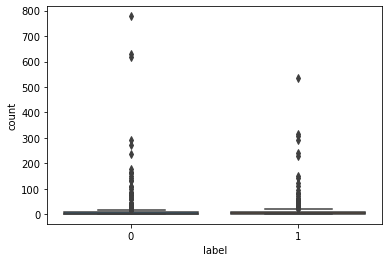

In [214]:
sns.boxplot(data=df, x='label', y='count');

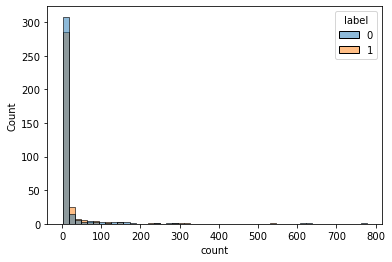

In [220]:
sns.histplot(data=df, x='count', hue='label', bins=50);

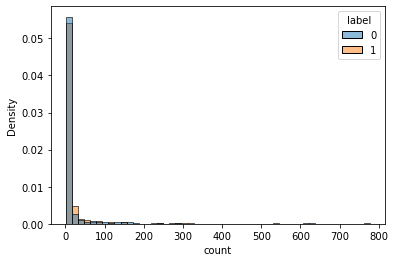

In [221]:
sns.histplot(data=df, x='count', hue='label', bins=50, stat='density', common_norm=False);

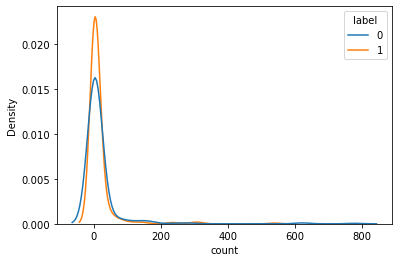

In [222]:
sns.kdeplot(x='count', data=df, hue='label', common_norm=False);

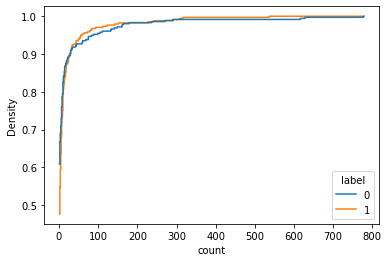

In [229]:
sns.histplot(x='count', data=df, hue='label', bins=len(df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False);

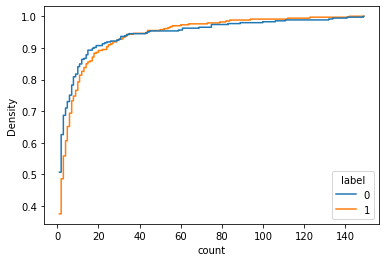

In [230]:
# Considering instances which their cascades count is less than 150
sns.histplot(x='count', data=df[df['count']<150], hue='label', bins=len(df), 
             stat="density", element="step", fill=False, cumulative=True, 
             common_norm=False);

In [227]:
df.shape, df[df['count']<200].shape, df[df['count']<150].shape

((695, 2), (683, 2), (678, 2))

According to the graph above, if we sort both classes from the smallest propagation network to the largest, a pattern can be detected. In the first 93 percent of propagation networks, real news has a larger network, while in the last 7 percent, the propagation networks of fake instances are wider.